# Sidekick - Features Extraction
In this notebook, we try to find new features, mainly extracted from the backers and twitter data.

In [58]:
%matplotlib inline
from __future__ import print_function
import os
import sys
sys.path.insert(0, os.path.abspath('../utils/')) # Add sibling to Python path
sys.path.insert(0, os.path.abspath('../src/')) # Add sibling to Python path
sys.stdout.flush() # Print output on the fly in Notebook
import matplotlib
matplotlib.rcParams['figure.figsize'] = (16,8)
#matplotlib.rcParams['figure.figsize'] = (20,20)
matplotlib.rcParams['font.size'] = 32
matplotlib.rcParams['legend.fontsize'] = 32
from IPython.display import display
import numpy as np
import pickle as cp
import matplotlib.pyplot as plt
from dataset import Sidekick
from sklearn import linear_model


def subsample(t, granularity):
    if granularity > 1.0 or granularity <= 0:
        raise ValueError("granularity must be in ]0, 1]")
    t0 = 0
    n_samples = int(np.ceil(granularity * t))
    if n_samples == 1:
        return [t-1]
    else:
        return np.linspace(t0, t-1, n_samples, dtype=int)
    
def mean_increment(money):
    d = np.diff(money)
    increments = [i for i in d if i != 0]
    if len(increments) > 0:
        return np.mean(increments)
    else:
        return 0
    
def evaluate(X_test, y_test, projects_test_filtered, model, normalized):
    se_successful = []
    se_failed = []
    se_total = []
    accuracy = 0
    for i, x_test in enumerate(X_test):
        if normalized:
            goal = 1
        else:
            p = projects_test_filtered[i]
            goal = float(p.goal)
        x_test = np.expand_dims(x_test, axis=0)
        #y_pred = x_test * regr.coef_ + regr.intercept_
        y_pred = model.predict(x_test)
        y_pred = y_pred[0]
        y_actual = y_test[i][0]
        se = (y_pred - y_actual)**2
        se_total.append(se)
        if y_test[i] >= 1.0:  # Project is successful
            se_successful.append(se)
        else:  # project is failed
            se_failed.append(se)
        if normalized:
            if (y_pred >= 1 and y_actual >= 1) or (y_pred < 1 and y_actual < 1):
                accuracy += 1
        else:
            if (y_pred / goal >= 1 and y_actual / goal >= 1) or (y_pred / goal < 1 and y_actual / goal < 1):
                accuracy += 1
        #else:
        #    print("Error:", i)

    rmse_successful = np.sqrt(np.mean(se_successful))
    rmse_failed = np.sqrt(np.mean(se_failed))
    rmse_total = np.sqrt(np.mean(se_total))
    accuracy /= float(len(y_test))

    print("Accuracy: ", accuracy)
    print("RMSE: ", rmse_total)
    print("RMSE successful: ", rmse_successful)
    print("RMSE failed: ", rmse_failed)

## Load data

In [59]:
sk = Sidekick()
sk.load(update=False)
successful = sk.successful()
failed = sk.failed()
projects_train, projects_test = sk.split(threshold=0.7)

Loading data set...
Data loaded.


## Filter out outliers

In [60]:
outlier_threshold = 10000
normalized = False

for p in np.append(projects_train, projects_test):
    p.normalized = normalized

projects_train_filtered = [p for p in projects_train if np.all([(m - outlier_threshold) <= 0 for m in p.money])]
projects_test_filtered = [p for p in projects_test if np.all([(m - outlier_threshold) <= 0 for m in p.money])]

print("Keeping %.2f%% of data" % (len(projects_train_filtered) / len(projects_train) * 100))

Keeping 83.97% of data


### Money-based features
We train the model for features extracted using the money time series up to time $t$ and using a level of granularity $\gamma$. 

In [65]:
t = 25
granularity = 0.01
samples = subsample(t, granularity)
n_samples = 1
T = 999
standardize = False
print(samples)
print(mean_increment(projects_train_filtered[0].money[samples]))

extractor1 = lambda a: a[-1]
extractor2 = lambda a: a[-1] / t
extractor3 = lambda a: mean_increment(a)
extractor4 = lambda a: np.max(np.diff(a))
extractor5 = lambda a: np.log(a[-1] + 1)
extractor6 = lambda a: a[-1] - 10 * t
mu = np.mean([extractor1(p.money[samples]) for p in projects_train_filtered])
mu_successful = np.mean([extractor1(p.money[samples]) for p in projects_train_filtered if p.successful])
mu_failed = np.mean([extractor1(p.money[samples]) for p in projects_train_filtered if not p.successful])
print(mu, mu_failed, mu_successful, 10 * t)
extractor7 = lambda a: a[-1] - mu
extractor8 = lambda a: a[-1] - mu_successful
extractor9 = lambda a: a[-1] - mu_failed
last_N = 10
extractor10 = lambda a: mean_increment(a[last_N:t-1])

processing = extractor5

X_train = np.ndarray(shape=(len(projects_train_filtered), n_samples), buffer=np.array([processing(p.money[samples]) for p in projects_train_filtered]), dtype=float)
y_train = np.expand_dims(np.array([p.money[T] for p in projects_train_filtered]), axis=1)
X_test = np.ndarray(shape=(len(projects_test_filtered), n_samples), buffer=np.array([processing(p.money[samples]) for p in projects_test_filtered]), dtype=float)
y_test = np.expand_dims(np.array([p.money[T] for p in projects_test_filtered]), axis=1)

X_train_successful = [processing(p.money[samples]) for p in projects_train_filtered if p.successful]
y_train_successful = [p.money[T] for p in projects_train_filtered if p.successful]
X_train_failed = [processing(p.money[samples]) for p in projects_train_filtered if not p.successful]
y_train_failed = [p.money[T] for p in projects_train_filtered if not p.successful]

X_test_successful = [processing(p.money[samples]) for p in projects_test_filtered if p.successful]
y_test_successful = [p.money[T] for p in projects_test_filtered if p.successful]
X_test_failed = [processing(p.money[samples]) for p in projects_test_filtered if not p.successful]
y_test_failed = [p.money[T] for p in projects_test_filtered if not p.successful]    

if standardize:
    X_train_mean = np.mean(X_train, axis=0)
    X_train_std = np.std(X_train, axis=0)
    X_train = (X_train - X_train_mean) / X_train_std
    X_test = (X_test - X_train_mean) / X_train_std
    
# Create linear regression object
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

#for i, x in enumerate(X_train):
#    if x < 0:
#        print(i, x)

print('Linear regression: f(x) = %0.2f + %0.2fx' % (regr.intercept_[0], regr.coef_[0, 0]))

print("Successful (train): %s (%.2f%%)" % (len(X_train_successful), len(X_train_successful) / len(projects_train_filtered) * 100))
print("Failed (train): %s (%.2f%%)" % (len(X_train_failed), len(X_train_failed) / len(projects_train_filtered) * 100))

print("Successful (test): %s (%.2f%%)" % (len(X_test_successful), len(X_test_successful) / len(projects_test_filtered) * 100))
print("Failed (test): %s (%.2f%%)" % (len(X_test_failed), len(X_test_failed) / len(projects_test_filtered) * 100))

plt.plot(X_train_successful, y_train_successful, 'xg', label="Successful")
plt.plot(X_train_failed, y_train_failed, 'xr', alpha=0.8, label="Failed")

#plt.plot(X_train, y_train, 'xb')

x = np.linspace(plt.xlim()[0], plt.xlim()[1], 1000)
y_pred = x * regr.coef_ + regr.intercept_
plt.plot(x, y_pred[0], 'b-', lw=2)
plt.title("Features up to time %s" % t)
plt.legend(loc='best', numpoints=1)
plt.grid()
plt.xlabel("Amount money at time %s ($)" % t)
plt.ylabel("Final amount of money ($)")
#plt.xlim([-300, plt.xlim()[1]])
plt.ylim([0, outlier_threshold])
plt.savefig("increments_t_%s_linear_regression.pdf" % t)
plt.show()
evaluate(X_test, y_test, projects_test_filtered, model=regr, normalized=normalized)

[24]
0


IndexError: index 24 is out of bounds for axis 0 with size 1

Goal: $9999
Pledged: $7567


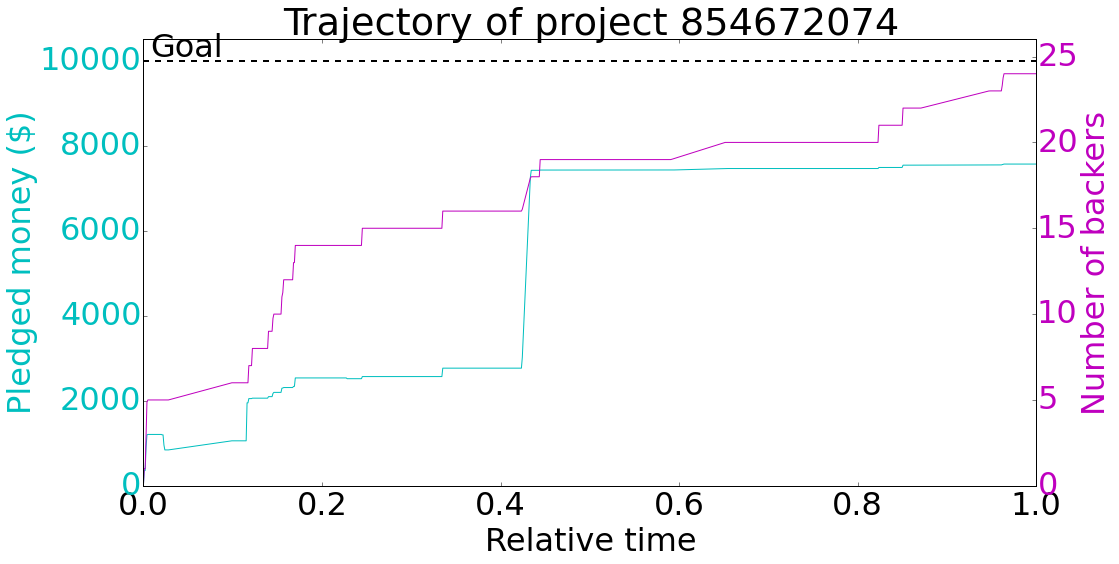

In [104]:
projects_train_filtered[5455].normalized = True
projects_train_filtered[5455].plot()

### Backers features

Linear regression: f(x) = 140.11 + 1463.27x


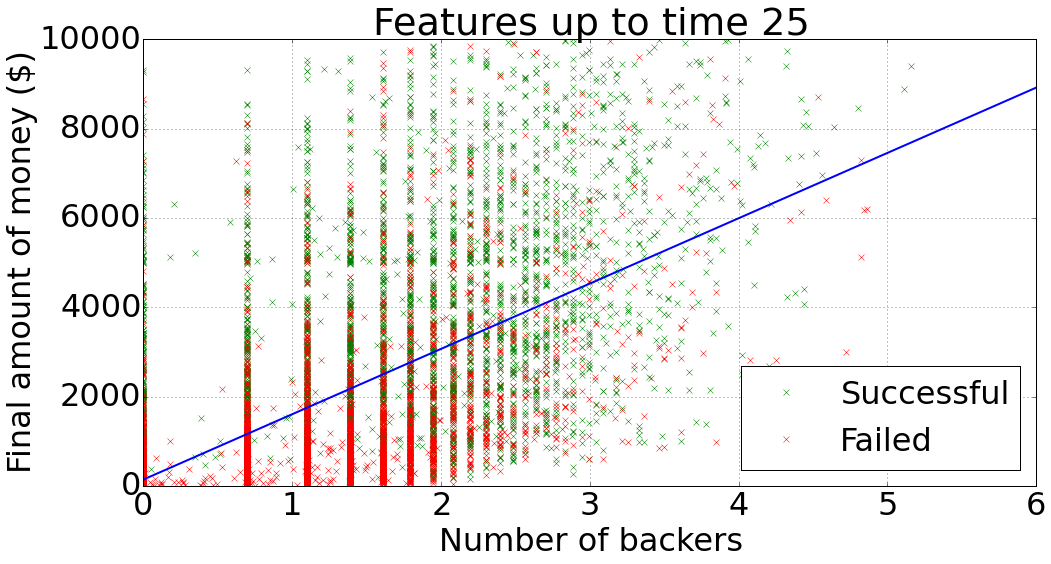

Accuracy:  0.7704958883628208
RMSE:  1874.38135953
RMSE successful:  1952.32454832
RMSE failed:  154.227178523


In [116]:
t = 25
granularity = 1
samples = subsample(t, granularity)
n_samples = 1

T = 999
standardize = False
extractor1 = lambda a: a[t-1]
extractor2 = lambda a: np.mean(a)
extractor3 = lambda a: np.mean(np.diff(a))
extractor4 = lambda a: np.log(a[t-1] + 1)

processing = extractor4

X_train = np.ndarray(shape=(len(projects_train_filtered), n_samples), buffer=np.array([processing(p.backers[samples]) for p in projects_train_filtered]), dtype=float)
y_train = np.expand_dims(np.array([p.money[T] for p in projects_train_filtered]), axis=1)
X_test = np.ndarray(shape=(len(projects_test_filtered), n_samples), buffer=np.array([processing(p.backers[samples]) for p in projects_test_filtered]), dtype=float)
y_test = np.expand_dims(np.array([p.money[T] for p in projects_test_filtered]), axis=1)

X_train_successful = [processing(p.backers[samples]) for p in projects_train_filtered if p.successful]
y_train_successful = [p.money[T] for p in projects_train_filtered if p.successful]
X_train_failed = [processing(p.backers[samples]) for p in projects_train_filtered if not p.successful]
y_train_failed = [p.money[T] for p in projects_train_filtered if not p.successful]

X_test_successful = [processing(p.backers[samples]) for p in projects_test_filtered if p.successful]
y_test_successful = [p.money[T] for p in projects_test_filtered if p.successful]
X_test_failed = [processing(p.backers[samples]) for p in projects_test_filtered if not p.successful]
y_test_failed = [p.money[T] for p in projects_test_filtered if not p.successful]    

if standardize:
    X_train_mean = np.mean(X_train, axis=0)
    X_train_std = np.std(X_train, axis=0)
    X_train = (X_train - X_train_mean) / X_train_std
    X_test = (X_test - X_train_mean) / X_train_std
    
# Create linear regression object
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

print('Linear regression: f(x) = %0.2f + %0.2fx' % (regr.intercept_[0], regr.coef_[0, 0]))

plt.plot(X_train_successful, y_train_successful, 'xg', label="Successful")
plt.plot(X_train_failed, y_train_failed, 'xr', alpha=1, label="Failed")

#plt.plot(X_train, y_train, 'xb')

x = np.linspace(plt.xlim()[0], plt.xlim()[1], 1000)
y_pred = x * regr.coef_ + regr.intercept_
plt.plot(x, y_pred[0], 'b-', lw=2)
plt.title("Features up to time %s" % t)
plt.legend(loc='best', numpoints=1)
plt.grid()
plt.xlabel("Number of backers")
plt.ylabel("Final amount of money ($)")
plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, outlier_threshold])
plt.savefig("increments_t_%s_linear_regression.pdf" % t)
plt.show()
evaluate(X_test, y_test, model=regr)

### Average contribution

Linear regression: f(x) = 278.54 + 624.17x


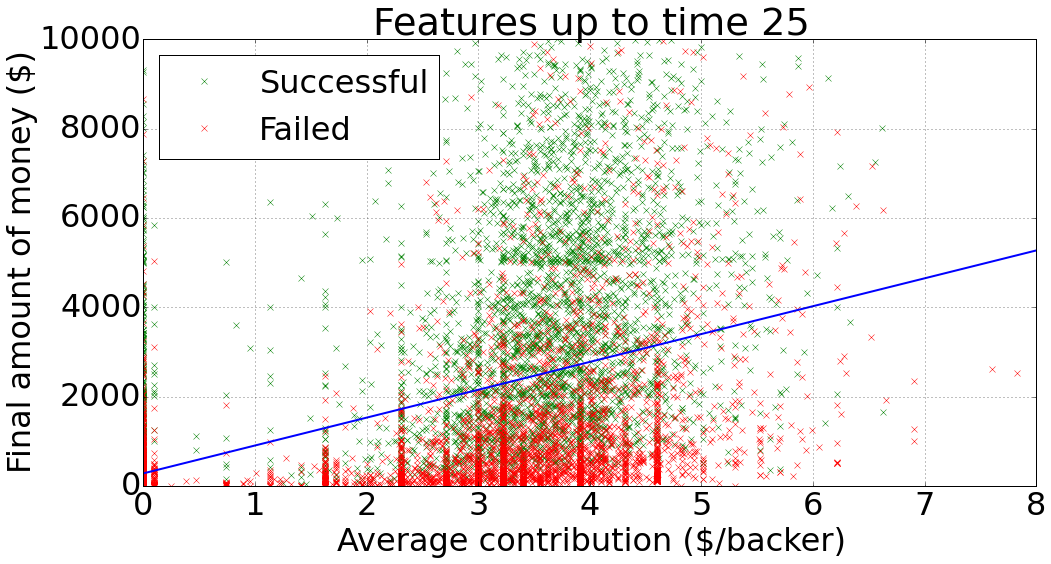

Accuracy:  0.7395963119860454
RMSE:  2066.27116188
RMSE successful:  2150.95821769
RMSE failed:  301.842838728


In [32]:
def average_contribution(money, backers):
    if backers > 0:
        return np.log(money / backers + 0.1)
    else:
        return 0

t = 25
granularity = 1
samples = subsample(t, granularity)
n_samples = 1

T = 999
standardize = False
last_sample = lambda a: a[t-1]

X_train = np.ndarray(shape=(len(projects_train_filtered), n_samples), buffer=np.array([average_contribution(last_sample(p.money[samples]), last_sample(p.backers[samples])) for p in projects_train_filtered]), dtype=float)
y_train = np.expand_dims(np.array([p.money[T] for p in projects_train_filtered]), axis=1)
X_test = np.ndarray(shape=(len(projects_test_filtered), n_samples), buffer=np.array([average_contribution(last_sample(p.money[samples]), last_sample(p.backers[samples])) for p in projects_test_filtered]), dtype=float)
y_test = np.expand_dims(np.array([p.money[T] for p in projects_test_filtered]), axis=1)

X_train_successful = [average_contribution(last_sample(p.money[samples]), last_sample(p.backers[samples])) for p in projects_train_filtered if p.successful]
y_train_successful = [p.money[T] for p in projects_train_filtered if p.successful]
X_train_failed = [average_contribution(last_sample(p.money[samples]), last_sample(p.backers[samples])) for p in projects_train_filtered if not p.successful]
y_train_failed = [p.money[T] for p in projects_train_filtered if not p.successful]

X_test_successful = [average_contribution(last_sample(p.money[samples]), last_sample(p.backers[samples])) for p in projects_test_filtered if p.successful]
y_test_successful = [p.money[T] for p in projects_test_filtered if p.successful]
X_test_failed = [average_contribution(last_sample(p.money[samples]), last_sample(p.backers[samples])) for p in projects_test_filtered if not p.successful]
y_test_failed = [p.money[T] for p in projects_test_filtered if not p.successful]    

# Create linear regression object
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

print('Linear regression: f(x) = %0.2f + %0.2fx' % (regr.intercept_[0], regr.coef_[0, 0]))

plt.plot(X_train_successful, y_train_successful, 'xg', label="Successful")
plt.plot(X_train_failed, y_train_failed, 'xr', alpha=1, label="Failed")

#plt.plot(X_train, y_train, 'xb')

x = np.linspace(plt.xlim()[0], plt.xlim()[1], 1000)
y_pred = x * regr.coef_ + regr.intercept_
plt.plot(x, y_pred[0], 'b-', lw=2)
plt.title("Features up to time %s" % t)
plt.legend(loc='best', numpoints=1)
plt.grid()
plt.xlabel("Average contribution ($/backer)")
plt.ylabel("Final amount of money ($)")
plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, outlier_threshold])
plt.savefig("increments_t_%s_linear_regression.pdf" % t)
plt.show()
evaluate(X_test, y_test, model=regr)

### Tweets features

Linear regression: f(x) = 1884.34 + 704.83x


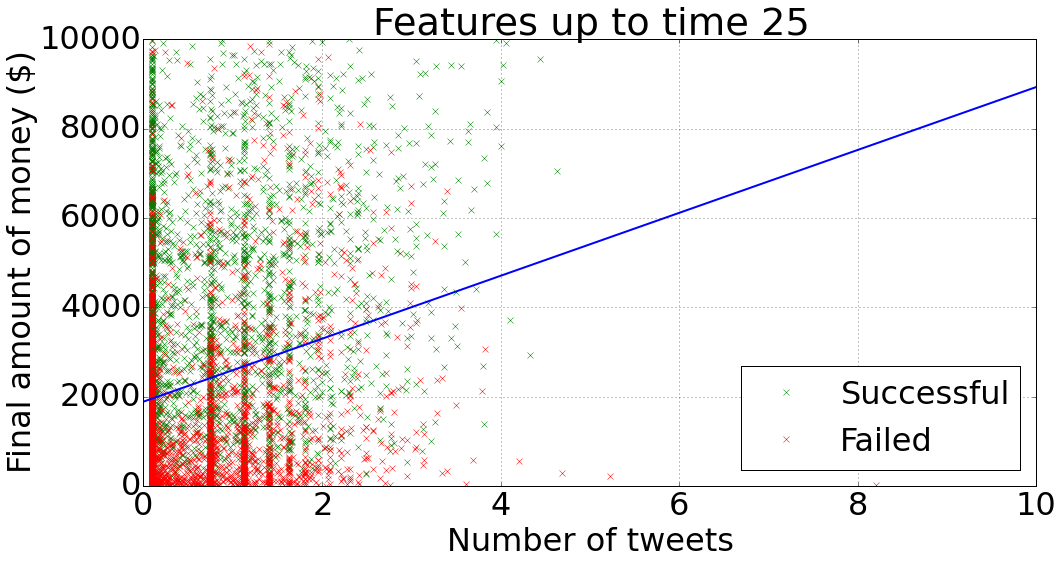

Accuracy:  0.7094443060054821
RMSE:  2141.83968318
RMSE successful:  2198.43364205
RMSE failed:  1309.09268841


In [27]:
def average_contribution(money, backers):
    if backers > 0:
        return np.log(money / backers + 0.1)
    else:
        return 0

# Experiment parameters
t = 25
granularity = 1
samples = subsample(t, granularity)
n_samples = 1
T = 999
standardize = False

#Data/time series
data1 = "number_tweets"
data2 = "number_retweets"
data3 = "number_tweets_replies"
data4 = "estimated_backers_number"
data5 = "number_tweeting_users"

# Feature extractors
processing1 = lambda a: a[t-1]
processing2 = lambda a: np.log(a[t-1] + 0.1)

# Combine
data = data5
processing = processing2

X_train = np.ndarray(shape=(len(projects_train_filtered), n_samples), buffer=np.array([processing(p.__getattribute__(data)[samples]) for p in projects_train_filtered]), dtype=float)
y_train = np.expand_dims(np.array([p.money[T] for p in projects_train_filtered]), axis=1)
X_test = np.ndarray(shape=(len(projects_test_filtered), n_samples), buffer=np.array([processing(p.__getattribute__(data)[samples]) for p in projects_test_filtered]), dtype=float)
y_test = np.expand_dims(np.array([p.money[T] for p in projects_test_filtered]), axis=1)

X_train_successful = [processing(p.__getattribute__(data)[samples]) for p in projects_train_filtered if p.successful]
y_train_successful = [p.money[T] for p in projects_train_filtered if p.successful]
X_train_failed = [processing(p.__getattribute__(data)[samples]) for p in projects_train_filtered if not p.successful]
y_train_failed = [p.money[T] for p in projects_train_filtered if not p.successful]

X_test_successful = [processing(p.__getattribute__(data)[samples]) for p in projects_test_filtered if p.successful]
y_test_successful = [p.money[T] for p in projects_test_filtered if p.successful]
X_test_failed = [processing(p.__getattribute__(data)[samples]) for p in projects_test_filtered if not p.successful]
y_test_failed = [p.money[T] for p in projects_test_filtered if not p.successful]    

# Create linear regression object
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

print('Linear regression: f(x) = %0.2f + %0.2fx' % (regr.intercept_[0], regr.coef_[0, 0]))

plt.plot(X_train_successful, y_train_successful, 'xg', label="Successful")
plt.plot(X_train_failed, y_train_failed, 'xr', alpha=1, label="Failed")

#plt.plot(X_train, y_train, 'xb')

x = np.linspace(plt.xlim()[0], plt.xlim()[1], 1000)
y_pred = x * regr.coef_ + regr.intercept_
plt.plot(x, y_pred[0], 'b-', lw=2)
plt.title("Features up to time %s" % t)
plt.legend(loc='best', numpoints=1)
plt.grid()
plt.xlabel("Number of tweets")
plt.ylabel("Final amount of money ($)")
plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, outlier_threshold])
plt.savefig("increments_t_%s_linear_regression.pdf" % t)
plt.show()
evaluate(X_test, y_test, model=regr)